In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
###custom colormap For Filter 2 and 4
from matplotlib.colors import ListedColormap
import matplotlib
col_dict = {1: "#004488",
            2: "#E69F00",
            3: "#007F5F",
            4: "#D73027"}
            #7: "green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(["solubility", "biology and upwelling", "biology", "upwelling"])
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

In [3]:
pathp='/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
corr=xr.open_dataset(pathf+'3x3box_median_corr_monthly_0181-0190_all.nc', chunks='auto')
dsa=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_all.nc', chunks='auto')
grid=xr.open_dataset(pathf+'ocean_grid.nc')

corr=fix_grid(corr)
dsa=fix_grid(dsa)

co2=abs(dsa.dic_stf).mean(dim='time')
co2_cc=abs(dsa.dic_stf_1PctTo2X).mean(dim='time')

# Categorizing

In [4]:
solubility_ctrl=corr.corr_o2_stf_dic_stf.where(corr.corr_o2_stf_dic_stf>0)
solubility_cc=corr.corr_o2_stf_dic_stf_1PctTo2X.where(corr.corr_o2_stf_dic_stf_1PctTo2X>0)

solubility_ctrl=solubility_ctrl.where(~solubility_ctrl.notnull(), 1)
solubility_cc=solubility_cc.where(~solubility_cc.notnull(), 1)

bioorup_ctrl=corr.corr_o2_stf_dic_stf.where(corr.corr_o2_stf_dic_stf<0)
bioorup_cc=corr.corr_o2_stf_dic_stf_1PctTo2X.where(corr.corr_o2_stf_dic_stf_1PctTo2X<0)
both_ctrl=solubility_ctrl.where(~bioorup_ctrl.notnull(), 2)
both_cc=solubility_cc.where(~bioorup_cc.notnull(), 2)
#
biologie_ctrl=both_ctrl.where(both_ctrl==2).where(corr.corr_jp_dic_stf_ctrl > 0)
biologie_cc=both_cc.where(both_cc==2).where(corr.corr_jp_dic_stf_1PctTo2X > 0)
biologie_ctrl=biologie_ctrl.where(~biologie_ctrl.notnull(), 3)
biologie_cc=biologie_cc.where(~biologie_cc.notnull(), 3)

#
upwelling_ctrl=both_ctrl.where(both_ctrl==2).where(corr.corr_mld_dic_stf_ctrl > 0)
upwelling_cc=both_cc.where(both_cc==2).where(corr.corr_mld_dic_stf_1PctTo2X > 0)
upwelling_ctrl=upwelling_ctrl.where(~upwelling_ctrl.notnull(), 4)
upwelling_cc=upwelling_cc.where(~upwelling_cc.notnull(), 4)
#
#
###all together
filter=both_ctrl.fillna(0)+upwelling_ctrl.fillna(0)+biologie_ctrl.fillna(0) #1 sol, 2, 9both, 5 bio, 6 upwelling
filter=filter.where(filter!=6, 4).where(filter!=5, 3) #both + upw or bio -> upw or bio
#
####DOMINATION

filter9bio=filter.where(filter==9).where(biologie_ctrl>upwelling_ctrl)
filter=filter.where(~filter9bio.notnull(), 3)
filter9upw=filter.where(filter==9).where(biologie_ctrl<upwelling_ctrl)
filter=filter.where(~filter9upw.notnull(), 4)
filter=filter.where(filter!=0, np.nan)
#
#
#
#
filter_cc=both_cc.fillna(0)+upwelling_cc.fillna(0)+biologie_cc.fillna(0) #1 sol, 2, 9both, 5 bio, 6 upwelling
filter_cc=filter_cc.where(filter_cc!=6, 4).where(filter_cc!=5, 3) #both + upw or bio -> upw or bio
#
####DOMINATION

filter9bio_cc=filter_cc.where(filter_cc==9).where(biologie_cc>upwelling_cc)
filter_cc=filter_cc.where(~filter9bio_cc.notnull(), 3)
filter9upw_cc=filter_cc.where(filter_cc==9).where(biologie_cc<upwelling_cc)
filter_cc=filter_cc.where(~filter9upw_cc.notnull(), 4)
filter_cc=filter_cc.where(filter_cc!=0, np.nan)


In [5]:
area_grid=grid.area_t/1e+6
sol=area_grid.where(filter==1).sum(dim='xt_ocean')
bioup=area_grid.where(filter==2).sum(dim='xt_ocean')
bio=area_grid.where(filter==3).sum(dim='xt_ocean')
up=area_grid.where(filter==4).sum(dim='xt_ocean')

sol_cc=area_grid.where(filter_cc==1).sum(dim='xt_ocean')
bioup_cc=area_grid.where(filter_cc==2).sum(dim='xt_ocean')
bio_cc=area_grid.where(filter_cc==3).sum(dim='xt_ocean')
up_cc=area_grid.where(filter_cc==4).sum(dim='xt_ocean')

In [6]:
#filter.to_netcdf(pathf+'mesoscale_effects_old.nc')

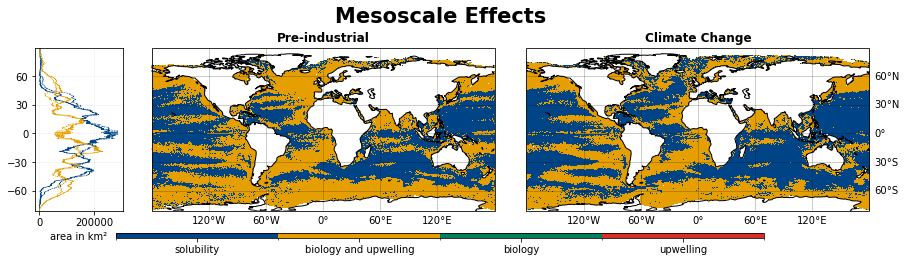

In [7]:
sol_alt=area_grid.where(both_ctrl==1).sum(dim='xt_ocean')
bioup_alt=area_grid.where(both_ctrl==2).sum(dim='xt_ocean')

sol_alt_cc=area_grid.where(both_cc==1).sum(dim='xt_ocean')
bioup_alt_cc=area_grid.where(both_cc==2).sum(dim='xt_ocean')

fig = plt.figure(figsize=(15,3),layout='compressed')
gs = gridspec.GridSpec(1, 3, width_ratios=[1,4,4], wspace=.1, hspace=.1)
ax1 = fig.add_subplot(gs[1],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[2],projection=ccrs.PlateCarree(central_longitude=0))

#
#
im1=both_ctrl.plot(ax=ax1, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

im2=both_cc.plot(ax=ax2, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

axs=[ax1, ax2]
for i in axs:
        gl = i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.2)
        gl.xlabels_top = False
        gl.ylabels_left = False
        i.coastlines()
        if i==ax1:
            gl.ylabels_right=False
#

####LINEPLOTS
ax0 = fig.add_subplot(gs[0])
sol_alt.plot(ax=ax0, c='#004488',y='yt_ocean', linewidth=.7)
bioup_alt.plot(ax=ax0, c='#E69F00',y='yt_ocean', linewidth=.7)


sol_alt_cc.plot(ax=ax0, c='#004488',y='yt_ocean', linestyle='--', linewidth=.5)
bioup_alt_cc.plot(ax=ax0, c='#E69F00',y='yt_ocean', linestyle='--', linewidth=.5)

ax0.grid(c='lightgray', linewidth=.5, linestyle='dotted')
ax0.set_yticks([-60,-30,0,30,60])
ax0.set_ylim([-81.108632,89.978896])

###TITLES AND LABELS
ax1.set_title('Pre-industrial', fontweight='bold');
ax2.set_title('Climate Change', fontweight='bold');
ax0.set_xlabel('area in km²');
ax0.set_ylabel('')
ax0.set_title('')
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);
plt.suptitle('Mesoscale Effects', fontweight='bold', fontsize=21, y=1.07);

plt.savefig(pathp+'mesoscale_effects_area_duo_median.png', dpi=300, bbox_inches='tight');

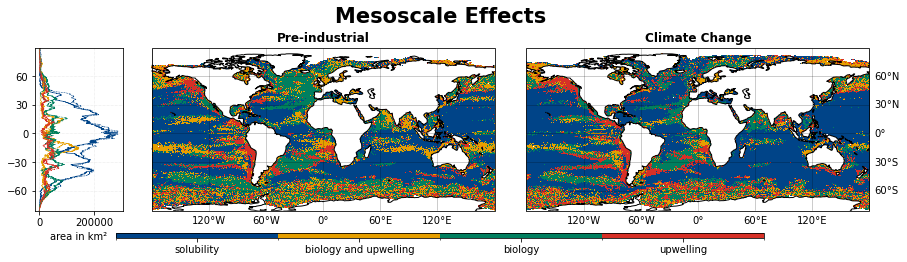

In [8]:
fig = plt.figure(figsize=(15,3),layout='compressed')
gs = gridspec.GridSpec(1, 3, width_ratios=[1,4,4], wspace=.1, hspace=.1)
ax1 = fig.add_subplot(gs[1],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[2],projection=ccrs.PlateCarree(central_longitude=0))

#
#
im1=filter.plot(ax=ax1, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

im2=filter_cc.plot(ax=ax2, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

axs=[ax1, ax2]
for i in axs:
        gl = i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.2)
        gl.xlabels_top = False
        gl.ylabels_left = False
        i.coastlines()
        if i==ax1:
            gl.ylabels_right=False
#

####LINEPLOTS
ax0 = fig.add_subplot(gs[0])
sol.plot(ax=ax0, c='#004488',y='yt_ocean', linewidth=.7)
bioup.plot(ax=ax0, c='#E69F00',y='yt_ocean', linewidth=.7)
bio.plot(ax=ax0, c='#007F5F',y='yt_ocean', linewidth=.7)
up.plot(ax=ax0, c='#D73027',y='yt_ocean', linewidth=.7)


sol_cc.plot(ax=ax0, c='#004488',y='yt_ocean', linestyle='--', linewidth=.5)
bioup_cc.plot(ax=ax0, c='#E69F00',y='yt_ocean', linestyle='--', linewidth=.5)
bio_cc.plot(ax=ax0, c='#007F5F',y='yt_ocean', linestyle='--', linewidth=.5)
up_cc.plot(ax=ax0, c='#D73027',y='yt_ocean', linestyle='--', linewidth=.5)

ax0.grid(c='lightgray', linewidth=.5, linestyle='dotted')
ax0.set_yticks([-60,-30,0,30,60])
ax0.set_ylim([-81.108632,89.978896])

###TITLES AND LABELS
ax1.set_title('Pre-industrial', fontweight='bold');
ax2.set_title('Climate Change', fontweight='bold');
ax0.set_xlabel('area in km²');
ax0.set_ylabel('')
ax0.set_title('')
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);
plt.suptitle('Mesoscale Effects', fontweight='bold', fontsize=21, y=1.07);

plt.savefig(pathp+'mesoscale_effects_area_jp_new_dom_median.png', dpi=300, bbox_inches='tight');

# Test

NameError: name 'sstco2' is not defined

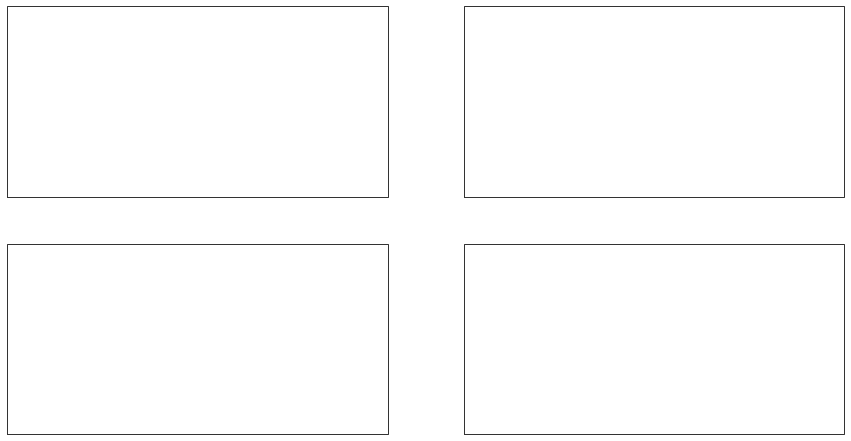

In [9]:
fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(15,8),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im= sstco2.plot(ax=axs[0],vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),add_colorbar=False)
ssto2.plot(ax=axs[1], vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),add_colorbar=False)
co2o2.corr_o2_stf_dic_stf.plot(ax=axs[2],vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),add_colorbar=False)
test.plot(ax=axs[3], vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap=cmo.balance, transform = ccrs.PlateCarree(),add_colorbar=False)

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

for i in range(4):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('SST/FCO2', fontsize=18, fontweight='bold');
axs[1].set_title('SST/FO2', fontsize=18, fontweight='bold');
axs[2].set_title('FCO2/FO2', fontsize=18, fontweight='bold');
axs[3].set_title('FCO2/FO2 + ; SST/FCO2 +; SST/FO2+', fontsize=18, fontweight='bold');
plt.subplots_adjust(hspace=0.05, wspace=0.1)

#axs[0].text(-200, 0, 'absolute mean', fontweight='bold', fontsize=18, rotation='vertical', va='center')
#axs[2].text(-215, 0, 'mesoscale \nanomalies', fontweight='bold', fontsize=18, rotation='vertical', va='center')

#plt.suptitle('Correlation FO2/FCO2', fontweight='bold', fontsize=21);
plt.savefig(pathp+'test_median.png', dpi=300, bbox_inches='tight');

# global absolutes, not up to date

In [37]:
path='/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/'
raw='/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5/control/'
jp=xr.open_dataset(path+'MOM5_monthly_0181-0190_jp.nc')
sst=xr.open_dataset(path+'MOM5_control_monthly_0181-0190.nc')
mld=xr.open_dataset(path+'ocean_mld_control_0181-0190.nc')
chl=xr.open_dataset(raw+'01810101.ocean_minibling_surf_field.nc')

In [33]:
jp_=jp.jp_uptake.mean('time')

In [35]:
sst_=sst.SST.mean('time')

In [39]:
mld_=mld.mld.mean('time')

In [41]:
chl_=chl.chl.mean('time')

In [43]:
jp_=fix_grid(jp_)
sst_=fix_grid(sst_)
chl_=fix_grid(chl_)
mld_=fix_grid(mld_)

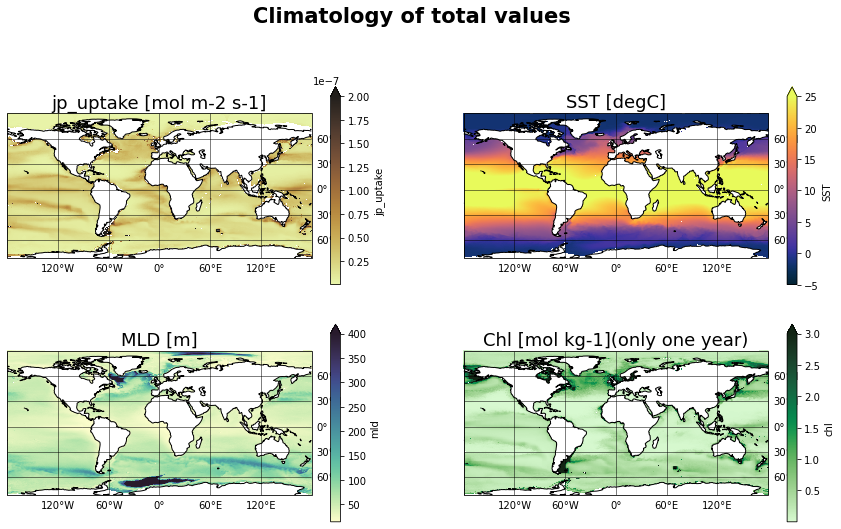

In [54]:
fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(15,8),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
jp_.plot(ax=axs[0], x='geolon_t', y='geolat_t', vmax=2e-07, cmap=cmo.turbid, transform = ccrs.PlateCarree(),add_colorbar=True)
sst_.plot(ax=axs[1],  x='geolon_t', y='geolat_t',vmin=-5, vmax=25,  cmap=cmo.thermal, transform = ccrs.PlateCarree(),add_colorbar=True)
mld_.plot(ax=axs[2], x='geolon_t', y='geolat_t',vmax=400, cmap=cmo.deep, transform = ccrs.PlateCarree(),add_colorbar=True)
chl_.plot(ax=axs[3], x='geolon_t', y='geolat_t', vmax=3, cmap=cmo.algae, transform = ccrs.PlateCarree(),add_colorbar=True)

#filter21.plot(ax=axs[0],vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap='RdBu_r', transform = ccrs.PlateCarree(), add_colorbar=False)
#filter2_cc1.plot(ax=axs[1], vmin=-1, vmax=1, x='geolon_t', y='geolat_t', cmap='RdBu_r', transform = ccrs.PlateCarree(), add_colorbar=False)


for i in range(4):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('jp_uptake [mol m-2 s-1]', fontsize=18);
axs[1].set_title('SST [degC]', fontsize=18);
axs[2].set_title('MLD [m]', fontsize=18);
axs[3].set_title('Chl [mol kg-1](only one year)', fontsize=18);

plt.suptitle('Climatology of total values', fontweight='bold', fontsize=21, y=1.02);

#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

# alle Masken, not up to date - contains an error

## solubility

In [90]:
sol=co2o2.where(co2o2>0)
sol_mask=sol.where(~sol.notnull(), 1)

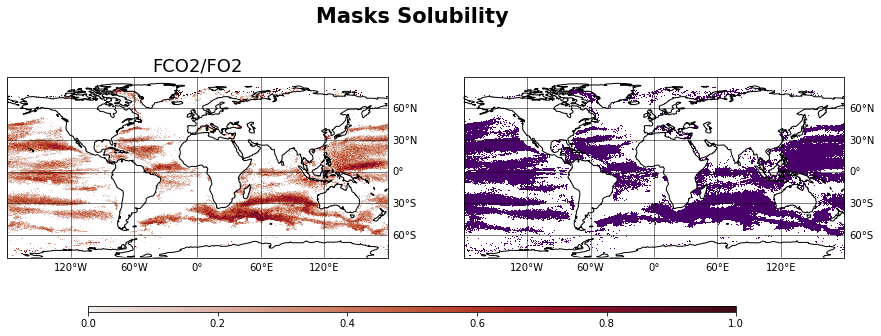

In [106]:
fig, axs= plt.subplots(nrows=1, ncols=2 , figsize=(15,4),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=sol.corr_o2_stf_dic_stf.plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cmo.amp,transform = ccrs.PlateCarree(),add_colorbar=False, vmin=0,vmax=1)
sol_mask.corr_o2_stf_dic_stf.plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap='RdPu',transform = ccrs.PlateCarree(),add_colorbar=False, vmin=0, vmax=1)

for i in range(2):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('FCO2/FO2', fontsize=18);
plt.suptitle('Masks Solubility', fontweight='bold', fontsize=21, y=1.06);

cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

In [107]:
upbio=co2o2.where(co2o2<0)
upbio_mask=upbio.where(~upbio.notnull(), 1)

In [109]:
bio=jp.where(jp>0)
upw=mld.where(mld<0)

bio_mask = bio.where(~bio.notnull(), 1)
upw_mask = upw.where(~upw.notnull(), 1)

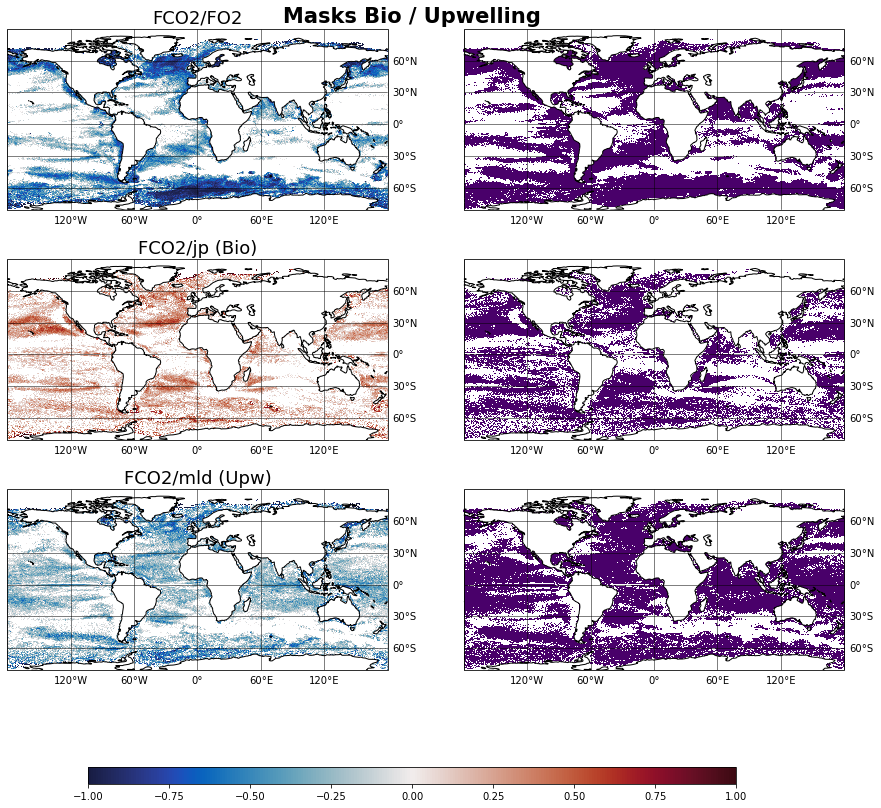

In [112]:
fig, axs= plt.subplots(nrows=3, ncols=2 , figsize=(15,12),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=upbio.corr_o2_stf_dic_stf.plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cmo.balance,transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1,vmax=1)
upbio_mask.corr_o2_stf_dic_stf.plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap='RdPu',transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1, vmax=1)
bio.corr_jp_dic_stf_ctrl.plot(ax=axs[2], x='geolon_t', y='geolat_t', cmap=cmo.balance,transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1,vmax=1)
bio_mask.corr_jp_dic_stf_ctrl.plot(ax=axs[3], x='geolon_t', y='geolat_t', cmap='RdPu',transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1, vmax=1)
upw.corr_mld_dic_stf_ctrl.plot(ax=axs[4], x='geolon_t', y='geolat_t', cmap=cmo.balance,transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1,vmax=1)
upw_mask.corr_mld_dic_stf_ctrl.plot(ax=axs[5], x='geolon_t', y='geolat_t', cmap='RdPu',transform = ccrs.PlateCarree(),add_colorbar=False, vmin=-1, vmax=1)


for i in range(6):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('FCO2/FO2', fontsize=18);
axs[2].set_title('FCO2/jp (Bio)', fontsize=18);
axs[4].set_title('FCO2/mld (Upw)', fontsize=18);
plt.suptitle('Masks Bio / Upwelling', fontweight='bold', fontsize=21, y=0.9);

cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');

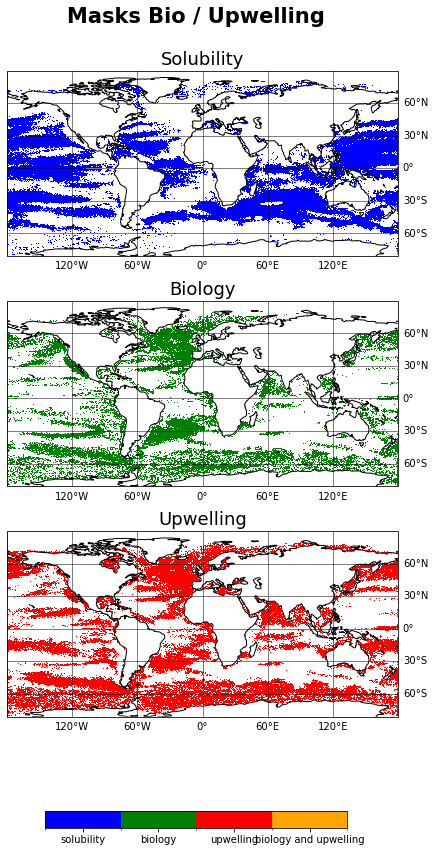

In [137]:
fig, axs= plt.subplots(nrows=3, ncols=1 , figsize=(7,12),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=solubility21_ctrl.plot(ax=axs[0], x='geolon_t', y='geolat_t', cmap=cm,norm=norm, transform = ccrs.PlateCarree(),add_colorbar=False)
biologie21_ctrl.plot(ax=axs[1], x='geolon_t', y='geolat_t', cmap=cm,norm=norm, transform = ccrs.PlateCarree(),add_colorbar=False)
upwelling21_ctrl.plot(ax=axs[2], x='geolon_t', y='geolat_t', cmap=cm,norm=norm, transform = ccrs.PlateCarree(),add_colorbar=False)

for i in range(3):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()

axs[0].set_title('Solubility', fontsize=18);
axs[1].set_title('Biology', fontsize=18);
axs[2].set_title('Upwelling', fontsize=18);
plt.suptitle('Masks Bio / Upwelling', fontweight='bold', fontsize=21, y=.95);

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);
#plt.savefig(pathp+'co2_o2_corr.png', dpi=300, bbox_inches='tight');